In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

# Transferència de coneixement

L'objectiu d'avui és aprendre com podem emprar arquitectures ja existents per resoldre els nostres problemes. 

Com objectius secundaris tenim:

1. Conèixer un nou conjunt de dades
2. Entendre en profunditat com són dos dels models més emprats.
3. Guardar i carregar xarxes neuronals

## Dades

El conjunt de dades [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) consta de 60.000 imatges en color de 32x32 pixels etiquetades en 10 classes, amb 6.000 imatges per classe. Hi ha 50.000 imatges d'entrenament i 10.000 imatges de _test_.


Si voleu normalitzar les dades, a continuació teniu els valors ja calculats:

  - mitjana: (0.4914, 0.4822, 0.4465)
  - desviació típica: (0.247, 0.243, 0.261)

Una altra funció que pot ser útil és `Resize(mida_desti)` que rep un enter com a paràmetre (la mida final).


In [32]:
USE_ALEXNET = True

train_batch_size = 64
test_batch_size = 100

img_size = (227, 227) if USE_ALEXNET else (224, 224)

# Definim una seqüència (composició) de transformacions
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), transforms.Resize(img_size)]
)

# Descarregam un dataset ja integrat en la llibreria Pytorch
train_data = datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10("./data", train=False, transform=transform)

# Transformam les dades en l'estructura necessaria per entrenar una xarxa
train_loader = torch.utils.data.DataLoader(train_data, train_batch_size)
test_loader = torch.utils.data.DataLoader(test_data, test_batch_size)

Files already downloaded and verified


In [33]:
train_data.data.shape, test_data.data.shape, train_loader.dataset.data.shape, test_loader.dataset.data.shape

((50000, 32, 32, 3),
 (10000, 32, 32, 3),
 (50000, 32, 32, 3),
 (10000, 32, 32, 3))

## Transfer learning (Definició de la xarxa)

En aquesta pràctica aplicarem la tècnica de _transfer learning_ a partir de dues de les xarxes més conegudes en el camp de visió per computador:

-[**AlexNet**](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf). (ImageNet Classification with Deep Convolutional Neural Network, 2012). La mida d'entrada de les imatges és de (227x227x3).Té prop de 60 milions de paràmetres entrenables.

[**MobileNet v3**](https://pytorch.org/vision/main/models/mobilenetv3.html): és una arquitectura de xarxa neuronal convolucional dissenyada per a aplicacions de visió per ordinador en dispositius mòbils i sistemes encastats. Va ser desenvolupada per Google a la seva sèrie MobileNet, que se centra en l'eficiència i el rendiment de les xarxes neuronals en dispositius amb recursos limitats, com ara telèfons mòbils. Té dues versions: _small_ amb configuracions que van dels 2 als 5 milions de paràmetres; _large_ amb uns 6 milions de paràmetres. La mida d'entrada de les imatges és de (224x224x3)

_Pytorch_ ens permet emprar aquestes xarxes de manera molt senzilla. [Més informació](https://pytorch.org/vision/stable/models.html).

Si el model que cercam no es troba integrat dins la llibreria _Pytorch_ és bastant probable que si la trobem a Huggingface.

Descarregarem AlexNet i a analitzar-la. En aquest cas no només ens baixam la seva arquitectura, també els pesos resultants de l'entrenament.

In [4]:
alex = models.alexnet(weights=True)

print("-"*50)
print("Arquitectura AlexNet")
print("-"*50)
alex

c:\Users\Sergi\miniconda3\envs\ml-notes\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Sergi/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:15<00:00, 16.1MB/s] 


--------------------------------------------------
Arquitectura AlexNet
--------------------------------------------------


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
mobilenet  = models.mobilenet_v3_small(weights=True)

print("-"*50)
print("Arquitectura MobileNet")
print("-"*50)
mobilenet

c:\Users\Sergi\miniconda3\envs\ml-notes\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\Sergi/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 28.3MB/s]


--------------------------------------------------
Arquitectura MobileNet
--------------------------------------------------


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

Hi ha diverses maneres de realitzar la tècnica de _TransferLearning_ les dues més conegudes són:

 - **"Congelar"** els pesos de la part d'extracció de característiques (la part convolucional) i crear un nou classificador que s'adapti al nostre problema. Això implica que només entrenam una part de la xarxa.
 - **Reentrenar tota la xarxa**.

Com que la nostra capacitat de càlcul és limitada, ens decantarem per la primera opció. Pensau que

 Per tal d'evitar el reentrenament necessitam canviar el valor de l'atribut  `requires_grad` al valor `False`. Aquest atribut és propietat de cada tensor. Podem recorrer els tensors mitjançant el següent codi:
 ```
for param in alex.features.parameters():
    param.requires_grad = False
 ```
 ### Feina a fer:

- Bloc 1
 1. Carregar la xarxa AlexNet i seleccionar la part d'extracció de característiques.
 2. Definir un entorn seqüencial on implementarem el classificador de la xarxa.
 3. Realitzar un entrenament: comparar rendiment (accuracy) i nombre de paràmetres.
 4. Provar de guardar la vostra xarxa i tornar-la a carregar. Classificar una imatge del conjunt de test.
- Bloc 2: Repetir el mateix procés que l'anterior amb la xarxa mobilenet v3.


In [8]:
for param in alex.parameters():
    param.requires_grad = False

for param in mobilenet.parameters():
    param.requires_grad = False

In [13]:

base = alex if USE_ALEXNET else mobilenet

my_net = nn.Sequential(base, nn.Flatten(1, -1), nn.Linear(1000, 10), nn.Softmax(dim=1))

## Entrenament

[shhht](https://github.com/tqdm/tqdm) si voleu canviar el resum de l'entrenament per una barra de progrés

In [36]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    
    model.train()

    loss_v = 0

    for batch_idx, (data, target) in (t:= tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}")):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target, reduction='mean') 
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and verbose:
            t.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
 
    return loss_v


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, total=len(test_loader), desc="Test"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='mean') 
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()
 
  
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss

In [37]:
torch.manual_seed(33)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    

epochs = 2
lr = 1e-3

model = my_net.to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Parameters ", pytorch_total_params)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Guardam el valor de pèrdua mig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

for epoch in range(0, epochs):
    train_l[epoch] = train(model, device, train_loader, optimizer, epoch)
    test_l[epoch]  = test(model, device, test_loader)

Parameters  10010


Epoch 0:   0%|          | 0/782 [00:00<?, ?it/s]c:\Users\Sergi\miniconda3\envs\ml-notes\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Train Epoch: 0 [0/50000 (0%)]	Loss: 2.050122, Average: 0.032033:   7%|▋         | 58/782 [01:05<13:35,  1.13s/it]


KeyboardInterrupt: 

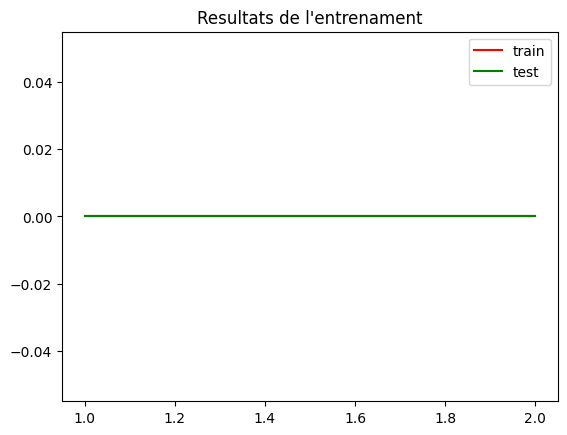

In [38]:
plt.title("Resultats de l'entrenament")
plt.plot(range(1, (epochs + 1)), train_l,  c="red", label="train")
plt.plot(range(1,  (epochs + 1)), test_l,  c="green", label="test")
plt.legend();